In [1]:
import pandas as pd
import urllib.request
import zipfile
url = 'https://github.com/mattharrison/datasets/raw/master/data/'\
'kaggle-survey-2018.zip'
fname = 'kaggle-survey-2018.zip'
member_name = 'multipleChoiceResponses.csv'
def extract_zip(src, dst, member_name):
    url = src
    fname = dst
    fin = urllib.request.urlopen(url)
    data = fin.read()
    with open(dst, mode='wb') as fout:
        fout.write(data)
    with zipfile.ZipFile(dst) as z:
        kag = pd.read_csv(z.open(member_name),low_memory=False)
        kag_questions = kag.iloc[0]
        raw = kag.iloc[1:]
        return raw

raw = extract_zip(url, fname, member_name)

In [2]:
def topn(ser, n=5, default='other'):
    counts = ser.value_counts()
    return ser.where(ser.isin(counts.index[:n]), default)

In [3]:
def tweak_kag(df_: pd.DataFrame) -> pd.DataFrame:
    """
    Tweak the Kaggle survey data and return a new DataFrame.
    This function takes a Pandas DataFrame containing Kaggle
    survey data as input and returns a new DataFrame. The
    modifications include extracting and transforming certain
    columns, renaming columns, and selecting a subset of columns.
    Parameters
    ----------
    df_ : pd.DataFrame
    The input DataFrame containing Kaggle survey data.
    Returns
    -------
    pd.DataFrame
    The new DataFrame with the modified and selected columns.
    """
    return (
        df_.assign(
            age=df_.Q2.str.slice(0,2).astype(int),
            education=df_.Q4.replace({'Master’s degree': 18,
                'Bachelor’s degree': 16,
                'Doctoral degree': 20,
                'Some college/university study without earning a bachelor’s degree': 13,
                'Professional degree': 19,
                'I prefer not to answer': None,
                'No formal education past high school': 12}),
            major=(df_.Q5
                .pipe(topn, n=3)
                .replace({
                    'Computer science (software engineering, etc.)': 'cs',
                    'Engineering (non-computer focused)': 'eng',
                    'Mathematics or statistics': 'stat'})
                ),
            years_exp=(df_.Q8.str.replace('+','', regex=False)
                .str.split('-', expand=True)
                .iloc[:,0]
                .astype(float)),
            compensation=(df_.Q9.str.replace('+','', regex=False)
                .str.replace(',','', regex=False)
                .str.replace('500000', '500', regex=False)
                .str.replace('I do not wish to disclose my approximate yearly compensation',
                '0', regex=False)
                .str.split('-', expand=True)
                .iloc[:,0]
                .fillna(0)
                .astype(int)
                .mul(1_000)
                ),
            python=df_.Q16_Part_1.fillna(0).replace('Python', 1),
            r=df_.Q16_Part_2.fillna(0).replace('R', 1),
            sql=df_.Q16_Part_3.fillna(0).replace('SQL', 1)
        )#assign
        .rename(columns=lambda col:col.replace(' ', '_'))
        .loc[:, 'Q1,Q3,age,education,major,years_exp,compensation,'
        'python,r,sql'.split(',')]
    )


In [4]:
from sklearn import base, pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder 

In [5]:
class TweakKagTransformer(base.BaseEstimator, base.TransformerMixin):

    def __init__(self, ycol=None):
        self.ycol = ycol

    def transform(self, X):
        return tweak_kag(X)

    def fit(self, X, y=None):
        return self


In [6]:
trans=TweakKagTransformer()

In [7]:
trans.fit_transform(raw)

C:\Users\Administrator\AppData\Local\Temp\ipykernel_6772\3735404497.py:20: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  education=df_.Q4.replace({'Master’s degree': 18,
C:\Users\Administrator\AppData\Local\Temp\ipykernel_6772\3735404497.py:49: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  python=df_.Q16_Part_1.fillna(0).replace('Python', 1),
C:\Users\Administrator\AppData\Local\Temp\ipykernel_6772\3735404497.py:50: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain th

,Q1,Q3,age,education,major,years_exp,compensation,python,r,sql
1,Female,United States of America,45,20.0,other,NaN,0,0,0,0
2,Male,Indonesia,30,16.0,eng,5.0,10000,0,0,1
3,Female,United States of America,30,18.0,cs,0.0,0,0,1,0
4,Male,United States of America,35,18.0,other,NaN,0,1,1,1
5,Male,India,22,18.0,stat,0.0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...
23855,Male,France,45,20.0,cs,5.0,250000,1,1,1
23856,Female,Turkey,25,18.0,eng,NaN,0,0,0,0
23857,Male,Turkey,22,18.0,cs,0.0,10000,0,0,0
23858,Male,United Kingdom of Great Britain and Northern I...,25,NaN,other,NaN,0,0,0,0


In [8]:
def get_rawX_y(df, y_col):
    raw = (df
    .query('Q3.isin(["United States of America", "China", "India"]) '
    'and Q6.isin(["Data Scientist", "Software Engineer"])')
    )
    return raw.drop(columns=[y_col]), raw[y_col]

In [9]:
%pip install feature_engine

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [10]:
from feature_engine import encoding, imputation

In [11]:
## Create a pipeline
kag_pl = pipeline.Pipeline(
    [('tweak', TweakKagTransformer()),
    ('cat', encoding.OneHotEncoder(top_categories=5,
    variables=['Q1', 'Q3', 'major'])),
    ('num_impute', imputation.MeanMedianImputer(imputation_method='median',
                                                variables=['education', 'years_exp']))]
)

In [12]:
from sklearn import model_selection
kag_X, kag_y = get_rawX_y(raw, 'Q6')

In [13]:
kag_X_train, kag_X_test, kag_y_train, kag_y_test = \
model_selection.train_test_split(
kag_X, kag_y, test_size=.3, random_state=42, stratify=kag_y)

In [14]:
X_train = kag_pl.fit_transform(kag_X_train, kag_y_train)

C:\Users\Administrator\AppData\Local\Temp\ipykernel_6772\3735404497.py:20: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  education=df_.Q4.replace({'Master’s degree': 18,
C:\Users\Administrator\AppData\Local\Temp\ipykernel_6772\3735404497.py:49: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  python=df_.Q16_Part_1.fillna(0).replace('Python', 1),
C:\Users\Administrator\AppData\Local\Temp\ipykernel_6772\3735404497.py:50: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain th

In [15]:
X_test = kag_pl.transform(kag_X_test)

C:\Users\Administrator\AppData\Local\Temp\ipykernel_6772\3735404497.py:20: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  education=df_.Q4.replace({'Master’s degree': 18,
C:\Users\Administrator\AppData\Local\Temp\ipykernel_6772\3735404497.py:49: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  python=df_.Q16_Part_1.fillna(0).replace('Python', 1),
C:\Users\Administrator\AppData\Local\Temp\ipykernel_6772\3735404497.py:50: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain th

In [16]:
from sklearn import tree

In [17]:
import matplotlib.pyplot as plt

In [18]:
import seaborn as sns
from seaborn import objects as so

In [19]:
accuracies=[]

for depth in range(1,15):
    between=tree.DecisionTreeClassifier(max_depth=depth)
    between.fit(X_train,kag_y_train)
    accuracies.append(between.score(X_test,kag_y_test))



In [20]:
df=pd.DataFrame(accuracies,columns=['accuracy'], index=range(1, len(accuracies)+1))

In [21]:
df

,accuracy
1,0.624309
2,0.692818
3,0.699448
4,0.713812
5,0.728177
6,0.722652
7,0.734807
8,0.727072
9,0.720442
10,0.703867


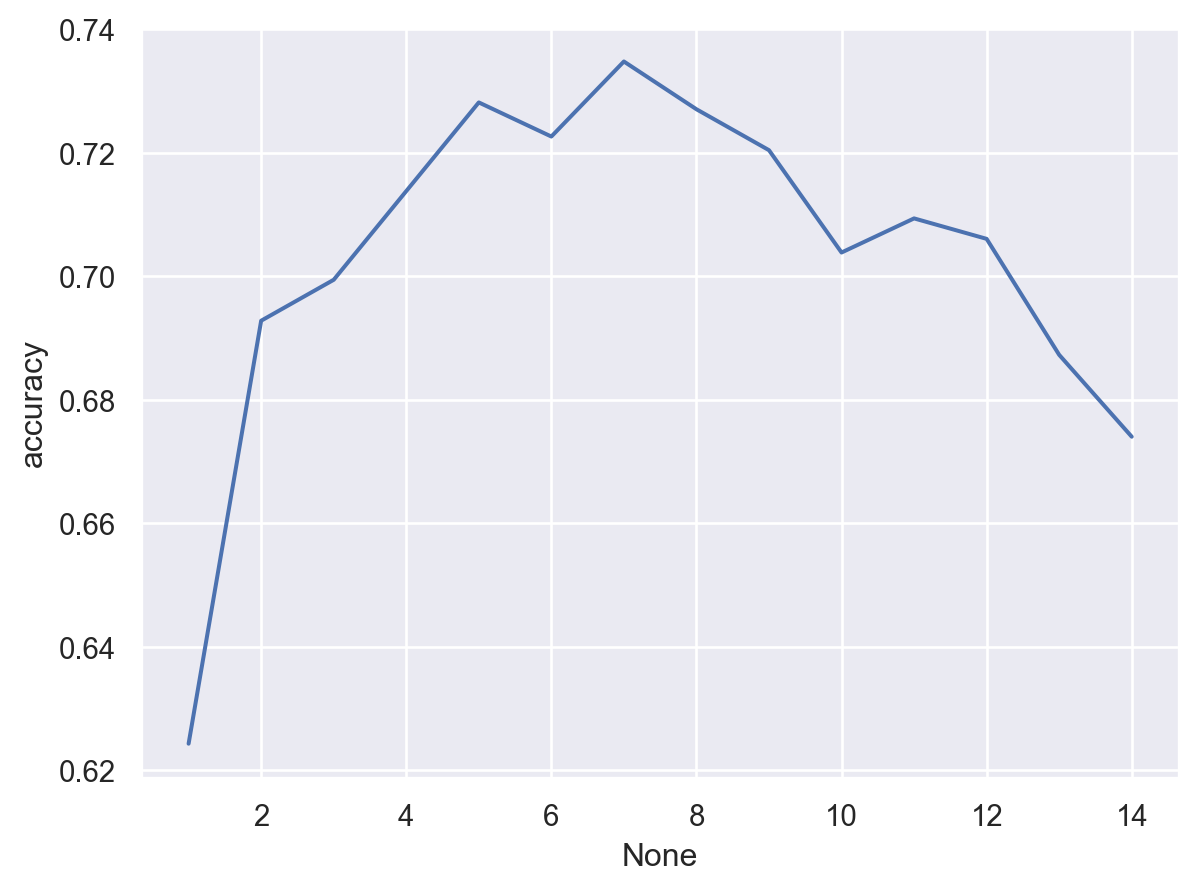

In [22]:

(
    so.Plot(df,x=df.index,y='accuracy')
    .add(so.Line())
)

In [23]:
between=tree.DecisionTreeClassifier(max_depth=7)
between.fit(X_train,kag_y_train)
between.score(X_test,kag_y_test)


0.7359116022099448

In [24]:
%pip install yellowbrick

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [25]:
%pip install setuptools

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


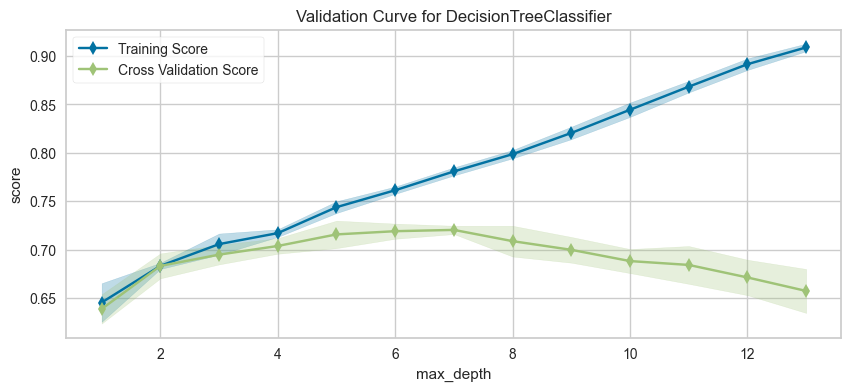

In [26]:
from yellowbrick.model_selection import validation_curve

fig, ax = plt.subplots(figsize=(10,4))
viz = validation_curve(tree.DecisionTreeClassifier(),
X=pd.concat([X_train, X_test]),
y=pd.concat([kag_y_train, kag_y_test]),
param_name='max_depth', param_range=range(1,14),
scoring='accuracy', cv=5, ax=ax, n_jobs=6)

In [27]:
from sklearn.model_selection import GridSearchCV

params = {
'max_depth': [3, 5, 7, 8],
'min_samples_leaf': [1, 3, 4, 5, 6],
'min_samples_split': [2, 3, 4, 5, 6],
}
grid_search = GridSearchCV(estimator=tree.DecisionTreeClassifier(),
param_grid=params, cv=4, n_jobs=-1,
verbose=1, scoring="accuracy")
grid_search.fit(pd.concat([X_train, X_test]),
pd.concat([kag_y_train, kag_y_test]))

Fitting 4 folds for each of 100 candidates, totalling 400 fits


GridSearchCV(cv=4, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'max_depth': [3, 5, 7, 8],
                         'min_samples_leaf': [1, 3, 4, 5, 6],
                         'min_samples_split': [2, 3, 4, 5, 6]},
             scoring='accuracy', verbose=1)

In [28]:
grid_search.best_params_


{'max_depth': 7, 'min_samples_leaf': 5, 'min_samples_split': 6}

In [29]:
between2 = tree.DecisionTreeClassifier(**grid_search.best_params_)

In [30]:
between2.fit(X_train, kag_y_train)


DecisionTreeClassifier(max_depth=7, min_samples_leaf=5, min_samples_split=6)

In [31]:
between2.score(X_test, kag_y_test)

0.7259668508287292

In [32]:
(pd.DataFrame(grid_search.cv_results_)
.sort_values(by='rank_test_score')
.style
.background_gradient(axis='rows')
)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score
69,0.023599,0.006064,0.007605,0.000853,7,5,6,"{'max_depth': 7, 'min_samples_leaf': 5, 'min_samples_split': 6}",0.706897,0.740053,0.709549,0.715803,0.718076,0.013094,1
65,0.019507,0.001081,0.008085,0.001288,7,5,2,"{'max_depth': 7, 'min_samples_leaf': 5, 'min_samples_split': 2}",0.706897,0.737401,0.706897,0.719788,0.717745,0.012509,2
66,0.019844,0.003978,0.010347,0.003153,7,5,3,"{'max_depth': 7, 'min_samples_leaf': 5, 'min_samples_split': 3}",0.706897,0.737401,0.709549,0.715803,0.717412,0.011985,3
67,0.020087,0.001188,0.008032,0.001571,7,5,4,"{'max_depth': 7, 'min_samples_leaf': 5, 'min_samples_split': 4}",0.705570,0.740053,0.706897,0.715803,0.717081,0.013834,4
68,0.020181,0.001978,0.008349,0.001649,7,5,5,"{'max_depth': 7, 'min_samples_leaf': 5, 'min_samples_split': 5}",0.708223,0.737401,0.706897,0.715803,0.717081,0.012214,4
71,0.019482,0.001643,0.008690,0.001194,7,6,3,"{'max_depth': 7, 'min_samples_leaf': 6, 'min_samples_split': 3}",0.701592,0.738727,0.705570,0.715803,0.715423,0.014419,6
62,0.019962,0.001865,0.009128,0.002114,7,4,4,"{'max_depth': 7, 'min_samples_leaf': 4, 'min_samples_split': 4}",0.706897,0.730769,0.709549,0.714475,0.715423,0.009268,7
74,0.020530,0.005956,0.009062,0.001202,7,6,6,"{'max_depth': 7, 'min_samples_leaf': 6, 'min_samples_split': 6}",0.700265,0.738727,0.705570,0.715803,0.715091,0.014745,8
72,0.021606,0.003200,0.007408,0.000477,7,6,4,"{'max_depth': 7, 'min_samples_leaf': 6, 'min_samples_split': 4}",0.700265,0.738727,0.705570,0.715803,0.715091,0.014745,8
70,0.019801,0.001235,0.012375,0.004743,7,6,2,"{'max_depth': 7, 'min_samples_leaf': 6, 'min_samples_split': 2}",0.700265,0.738727,0.705570,0.714475,0.714759,0.014740,10


In [33]:
results = model_selection.cross_val_score(
tree.DecisionTreeClassifier(max_depth=7),
X=pd.concat([X_train, X_test], axis='index'),
y=pd.concat([kag_y_train, kag_y_test], axis='index'),
cv=4
)

In [34]:
results

array([0.69761273, 0.73607427, 0.70026525, 0.71447543])

In [35]:
results.mean()

np.float64(0.712106921562204)

In [36]:
results = model_selection.cross_val_score(
tree.DecisionTreeClassifier(max_depth=7,min_samples_leaf=5,min_samples_split=2),
X=pd.concat([X_train, X_test], axis='index'),
y=pd.concat([kag_y_train, kag_y_test], axis='index'),
cv=4
)

In [37]:
results

array([0.70557029, 0.74005305, 0.70954907, 0.71580345])